In [1]:
from image_dataset import create_dataloader
from torchvision import transforms
from matplotlib.patches import Rectangle
import timm
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
16*32

512

In [3]:

final_shape = 16
patch_size = 32
new_size = (final_shape*patch_size, final_shape*patch_size)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda img: img.repeat(3//img.shape[0], 1, 1)),
    transforms.Resize(new_size),
                       ]
                              )
dataloader = create_dataloader(
    data_type = 'train',
    selected_categories = ['person', ],
    selected_output = ['bbox', ],
    new_size = new_size,
    patch_size = patch_size,
    transform = transform,
    batch_size = 4,
    dataset_size = 100
    )


In [4]:
test_data = next(iter(dataloader))
for key, value in test_data.items():
    print(key, value.shape)

images torch.Size([4, 3, 512, 512])
output_to_rpns torch.Size([4, 16, 16, 1])
bboxs torch.Size([9, 4])
category_ids torch.Size([9])
center_widths torch.Size([9])
center_heights torch.Size([9])
img_ids torch.Size([9])


In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import transformers
import torch.optim as optim
class ResNetModel(nn.Module):
  def __init__(self, resnet_config, output_dim, anchor_size, device='cpu'):
    super(ResNetModel, self).__init__()
    self.baseline = transformers.ResNetModel(resnet_config).to(device)
    self.output_dim = output_dim
    self.anchor_size = anchor_size
    self.lin1 = nn.Linear(resnet_config.hidden_sizes[-1],
                                1024,
                                device=device)
    self.output_rpn = nn.Linear(1024,
                                anchor_size,
                                device=device)

  def forward(self, x):
    last_hidden_state, _ = self.baseline(x, return_dict=False)
    last_hidden_state = last_hidden_state.permute(0, 2, 3, 1)
    # last_hidden_state = output['last_hidden_state']
    x = self.lin1(last_hidden_state)
    x = F.gelu(x)
    rpn_output = self.output_rpn(x)
    temp_shape = rpn_output.shape
    return rpn_output.reshape(temp_shape[:-1] + (self.anchor_size, )), last_hidden_state

class InceptionModel(nn.Module):
  def __init__(self, output_dim, anchor_size, if_pretrained, device='cpu'):
    super(InceptionModel, self).__init__()
    model = timm.create_model('inception_v3', pretrained=if_pretrained).to(device)
    baseline = nn.Sequential(*list(model.children())[:-3])
    self.baseline = baseline
    self.output_dim = output_dim
    self.anchor_size = anchor_size
    self.lin1 = nn.Linear(2048,
                                1024,
                                device=device)
    self.output_rpn = nn.Linear(1024,
                                anchor_size,
                                device=device)

  def forward(self, x):
    last_hidden_state = self.baseline(x)
    last_hidden_state = last_hidden_state.permute(0, 2, 3, 1)
    # last_hidden_state = output['last_hidden_state']
    x = self.lin1(last_hidden_state)
    x = F.gelu(x)
    rpn_output = self.output_rpn(x)
    temp_shape = rpn_output.shape
    return rpn_output.reshape(temp_shape[:-1] + (self.anchor_size, )), last_hidden_state

In [6]:
from torchmetrics.functional.detection import intersection_over_union

In [7]:
test_data.keys()

dict_keys(['images', 'output_to_rpns', 'bboxs', 'category_ids', 'center_widths', 'center_heights', 'img_ids'])

In [8]:
def convert_bbox(tensor, type_from='xywh', type_to='xyxy'):
    tensor_copy = tensor.clone()
    if type_from == 'xywh' and type_to == 'xyxy':
        tensor_copy[..., 2:] += tensor_copy[..., :2]
    return tensor_copy

In [9]:
torch.set_printoptions(sci_mode=False, precision=4)

In [10]:
converted_bboxes = convert_bbox(test_data['bboxs'])
test_data['bboxs'], converted_bboxes, test_data['img_ids']

(tensor([[248.0960, 354.1174,  23.7600,  50.9249],
         [194.7360, 355.4931,  34.3120,  65.9021],
         [223.8720, 362.1204,  21.6560,  59.4303],
         [421.4000, 315.0475,  11.9440,  50.1473],
         [264.9840, 346.3536,  20.4080,  44.6804],
         [152.8463,  79.6000, 192.5264, 122.5040],
         [ 34.3200,   2.3020, 335.8080, 502.7919],
         [152.6080,  65.5775, 234.4000, 439.5231],
         [298.3760,   7.1178, 167.5200, 504.8822]]),
 tensor([[248.0960, 354.1174, 271.8560, 405.0422],
         [194.7360, 355.4931, 229.0480, 421.3951],
         [223.8720, 362.1204, 245.5280, 421.5506],
         [421.4000, 315.0475, 433.3440, 365.1947],
         [264.9840, 346.3536, 285.3920, 391.0340],
         [152.8463,  79.6000, 345.3727, 202.1040],
         [ 34.3200,   2.3020, 370.1280, 505.0939],
         [152.6080,  65.5775, 387.0080, 505.1006],
         [298.3760,   7.1178, 465.8960, 512.0000]]),
 tensor([0, 0, 0, 0, 0, 1, 2, 3, 3]))

In [11]:
def generate_anchors(anchor_sizes, anchor_ratios, new_size):
    anchors = []
    for size in anchor_sizes:
        for ratio in anchor_ratios:
            size1 = ratio[0] * size
            size2 = ratio[1] * size
            #if size1 < new_size[0] and size2 < new_size[1]:
            anchors.append((min(size1, new_size[0]), 
                            min(size2, new_size[1])))
    anchors.append(new_size)
    return torch.tensor(list(set(anchors)))

In [12]:
anchor_sizes = [8, 16, 32, 64, 128, 256]
anchor_ratios = [(1, 1), (2, 1), (1, 2), (2, 3), (3, 2), (1, 5), (5, 1)]
anchors = generate_anchors(anchor_sizes, anchor_ratios, new_size=new_size)
print(anchors.shape, anchors)

torch.Size([39, 2]) tensor([[ 16,  32],
        [ 80,  16],
        [ 64,  32],
        [512, 128],
        [ 64,  96],
        [ 96,  64],
        [ 32,  64],
        [512, 256],
        [512, 512],
        [ 16,  16],
        [ 16,  80],
        [320,  64],
        [ 48,  32],
        [256, 128],
        [384, 256],
        [ 32,  48],
        [256, 256],
        [  8,   8],
        [256, 384],
        [256, 512],
        [160,  32],
        [ 24,  16],
        [192, 128],
        [ 32,  32],
        [  8,  40],
        [128,  64],
        [ 64,  64],
        [128, 128],
        [ 16,  24],
        [ 32, 160],
        [ 64, 128],
        [128, 192],
        [128, 256],
        [128, 512],
        [ 64, 320],
        [  8,  16],
        [ 32,  16],
        [ 16,   8],
        [ 40,   8]])


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_config = transformers.ResNetConfig(num_channels=3,
                                          #embedding_size=64,
                                          #hidden_sizes=(128, 256, 512, 1024, 2048),
                                          hidden_act='gelu',
                                          #depths = [3, 3, 3, 3, 3, 3],
                                          device = device)
model = ResNetModel(resnet_config,
                           output_dim=1,
                           anchor_size=len(anchors),
                           device = device)
'''
model = InceptionModel(output_dim=1,
                       anchor_size=len(anchors),
                       if_pretrained=False,
                       device = device)
'''
#for param in model.baseline.parameters():
#    param.requires_grad = False

'\nmodel = InceptionModel(output_dim=1,\n                       anchor_size=len(anchors),\n                       if_pretrained=False,\n                       device = device)\n'

In [14]:
test_output = model(test_data['images'].to(device))[0]
test_output.shape

torch.Size([4, 16, 16, 39])

In [15]:
def generate_possible_anchors(shape, anchors, patch_size, new_size):
    '''
    test = generate_possible_anchors((4, 16, 16), anchors, patch_size, new_size)
    '''
    anchor_length = len(anchors)
    x_pom = torch.arange(shape[0])
    y_pom = torch.arange(shape[1])
    anchor_pom = torch.arange(anchor_length)

    tensor = torch.zeros(shape + (anchor_length, 4))
    tensor[x_pom, :, :, 0] = (x_pom * patch_size + patch_size / 2).view(1, shape[0], 1, 1)
    tensor[:, y_pom, :, 1] = (y_pom * patch_size + patch_size / 2).view(1, 1, shape[1], 1)
    tensor[:, :, anchor_pom, 0] -= anchors[:, 0] / 2
    tensor[:, :, anchor_pom, 1] -= anchors[:, 1] / 2
    tensor[:, :, anchor_pom, 2] = anchors[:, 0].to(torch.float)
    tensor[:, :, anchor_pom, 3] = anchors[:, 1].to(torch.float)
    tensor[:, :, :, 2] += tensor[:, :, :, 0].clip(-torch.inf, 0)
    tensor[:, :, :, 3] += tensor[:, :, :, 1].clip(-torch.inf, 0)
    tensor[:, :, :, 2] -= (tensor[:, :, :, 0] + tensor[:, :, :, 2] - float(new_size[0])).clip(0, torch.inf)
    tensor[:, :, :, 3] -= (tensor[:, :, :, 1] + tensor[:, :, :, 3] - float(new_size[1])).clip(0, torch.inf)
    tensor[..., :2] = tensor[..., :2].clip(0, 512)
    return tensor




In [16]:
possible_anchors = generate_possible_anchors((final_shape, final_shape), anchors, patch_size, new_size)
possible_anchors.shape

torch.Size([16, 16, 39, 4])

In [17]:
poss_anchor = possible_anchors.clone()
#poss_anchor = poss_anchor.unsqueeze(-2).repeat(1, 1, 1, 2, 1)
bboxs = converted_bboxes[test_data['img_ids']==0]
poss_anchor.shape, bboxs.shape, test_data['bboxs'].shape

(torch.Size([16, 16, 39, 4]), torch.Size([5, 4]), torch.Size([9, 4]))

In [18]:
for x in bboxs:
    print(x)

tensor([248.0960, 354.1174, 271.8560, 405.0422])
tensor([194.7360, 355.4931, 229.0480, 421.3951])
tensor([223.8720, 362.1204, 245.5280, 421.5506])
tensor([421.4000, 315.0475, 433.3440, 365.1947])
tensor([264.9840, 346.3536, 285.3920, 391.0340])


In [19]:
def calculate_max_anchor_iou(anchors, bboxs):
    anchor_shape = anchors.shape
    output_list = [intersection_over_union(anchors.view(-1, 4), x.unsqueeze(0), aggregate=False).view(anchor_shape[:-1])
                  for x in bboxs]
    maxs = torch.max(torch.stack(output_list, dim=-1), dim=-1)
    return maxs.values, maxs.indices

test_calc_iou = calculate_max_anchor_iou(poss_anchor, bboxs)[0]
print(test_calc_iou.shape)

torch.Size([16, 16, 39])


In [20]:
test_iou = intersection_over_union(poss_anchor.reshape(-1, 4), bboxs[:1], aggregate=False)
test_iou.reshape(final_shape, final_shape, len(anchors)).shape

torch.Size([16, 16, 39])

In [21]:
def generate_target_iou_per_anchor(anchors, bboxs, img_ids, batch_size):
    batch_iou = []
    batch_indices_bbox = []
    for i in range(batch_size):
        bbox = bboxs[img_ids == i]
        iou, indices_bbox = calculate_max_anchor_iou(anchors, bbox)
        batch_iou.append(iou)
        batch_indices_bbox.append(indices_bbox)
    return torch.stack(batch_iou, dim=0), torch.stack(batch_indices_bbox, dim=0)

In [22]:
converted_bboxes[test_data['img_ids']==0]

tensor([[248.0960, 354.1174, 271.8560, 405.0422],
        [194.7360, 355.4931, 229.0480, 421.3951],
        [223.8720, 362.1204, 245.5280, 421.5506],
        [421.4000, 315.0475, 433.3440, 365.1947],
        [264.9840, 346.3536, 285.3920, 391.0340]])

In [23]:
test_target = generate_target_iou_per_anchor(convert_bbox(possible_anchors), converted_bboxes, test_data['img_ids'], 4)
test_target[0].max()

tensor(0.8827)

In [24]:
loss_fn_rpn = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = transformers.get_linear_schedule_with_warmup(optimizer=optimizer,
                                                                num_warmup_steps=3000,
                                                                num_training_steps=10000)

Epoch: 1, step: 35, last loss: 0.5335274338722229, num_ex: 20,             max pred iou: 0.6478104591369629,             mean pred iou: 0.39950692653656006             max target iou: 0.5787940621376038


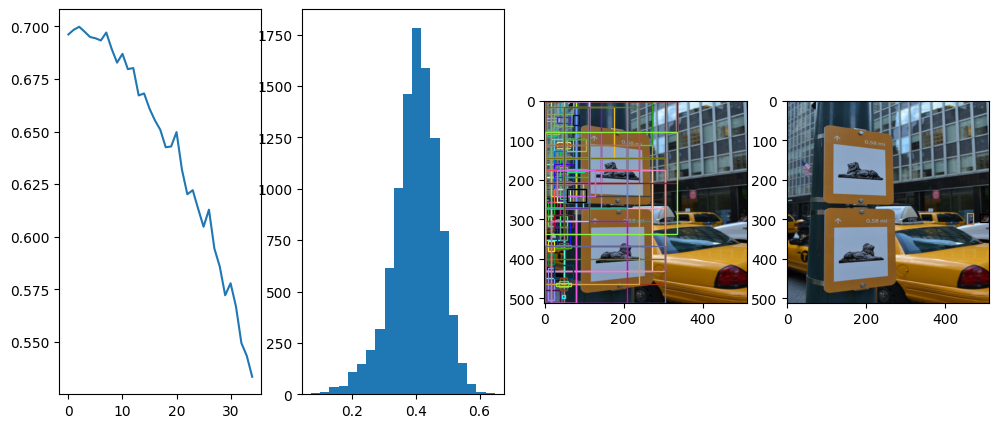

Epoch: 2, step: 70, last loss: 0.19075840711593628, num_ex: 20,             max pred iou: 0.4264736473560333,             mean pred iou: 0.1247887909412384             max target iou: 0.24638277292251587


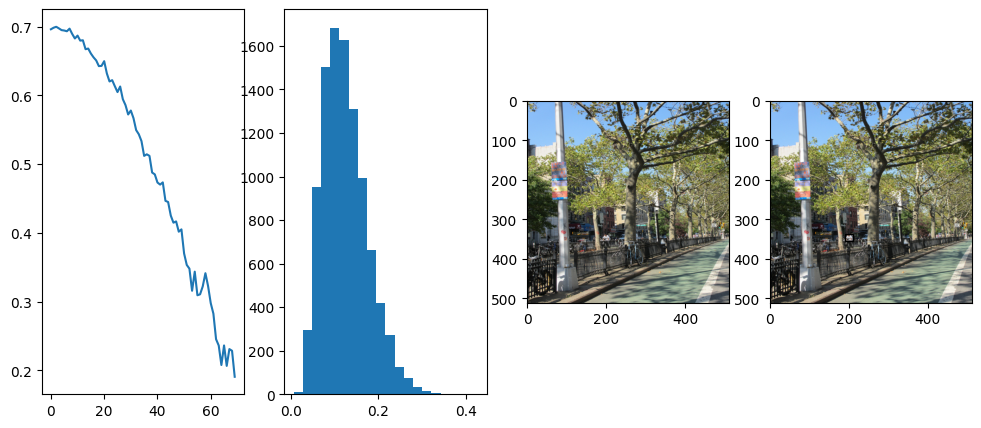

Epoch: 4, step: 105, last loss: 0.1979488730430603, num_ex: 31,             max pred iou: 0.3436882495880127,             mean pred iou: 0.046836480498313904             max target iou: 0.7986025214195251


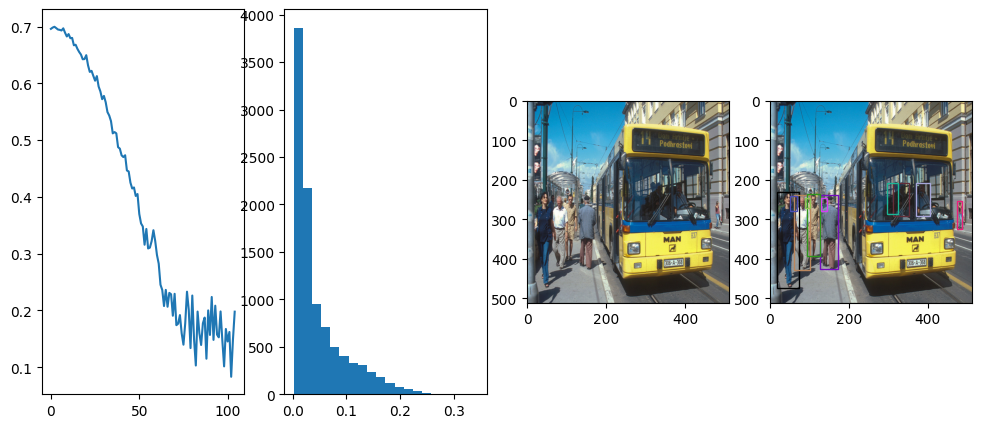

Epoch: 5, step: 140, last loss: 0.1425556242465973, num_ex: 5,             max pred iou: 0.3355086147785187,             mean pred iou: 0.04867347702383995             max target iou: 0.6730836629867554


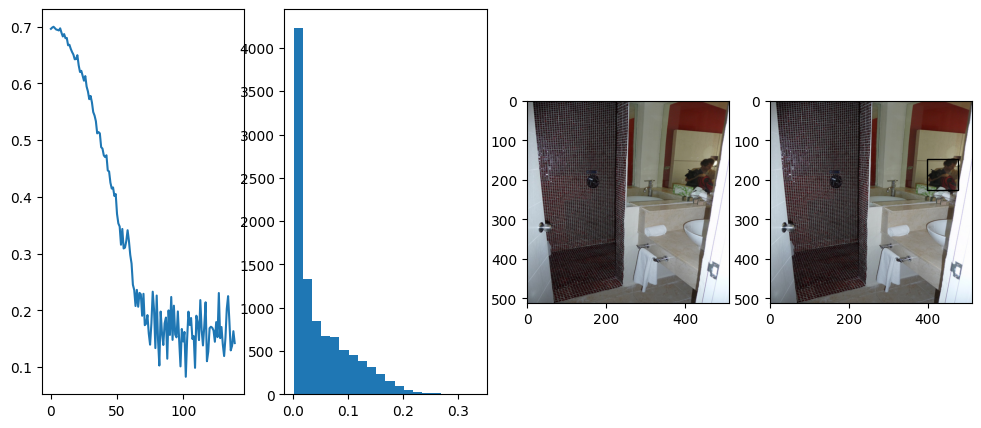

Epoch: 6, step: 175, last loss: 0.1601858288049698, num_ex: 17,             max pred iou: 0.2647002637386322,             mean pred iou: 0.04308893531560898             max target iou: 0.9488980770111084


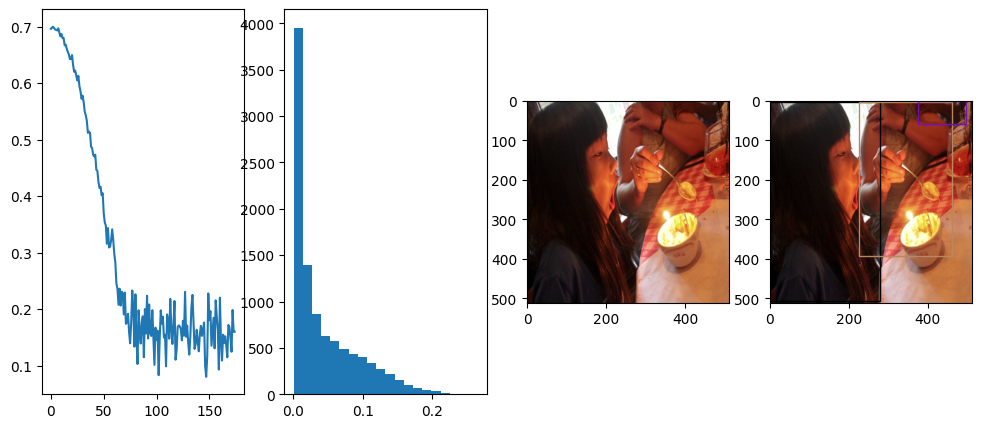

Epoch: 8, step: 210, last loss: 0.12392595410346985, num_ex: 21,             max pred iou: 0.3269878923892975,             mean pred iou: 0.046183373779058456             max target iou: 0.23202945291996002


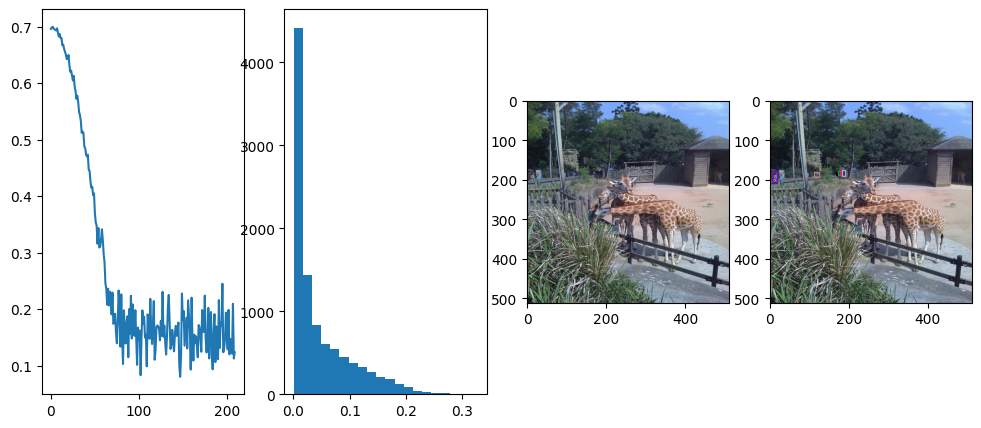

Epoch: 9, step: 245, last loss: 0.11927861720323563, num_ex: 23,             max pred iou: 0.34940627217292786,             mean pred iou: 0.04160843417048454             max target iou: 0.8148910403251648


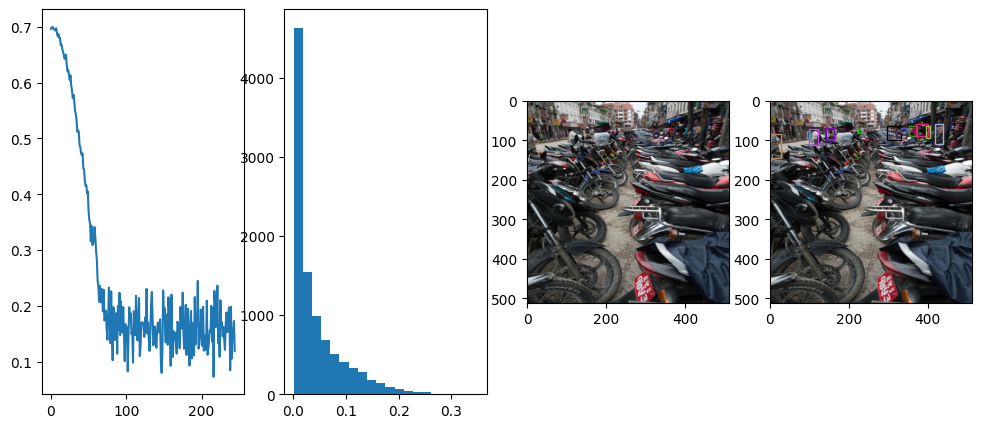

Epoch: 11, step: 280, last loss: 0.15023981034755707, num_ex: 11,             max pred iou: 0.39945778250694275,             mean pred iou: 0.04229864850640297             max target iou: 0.8251655697822571


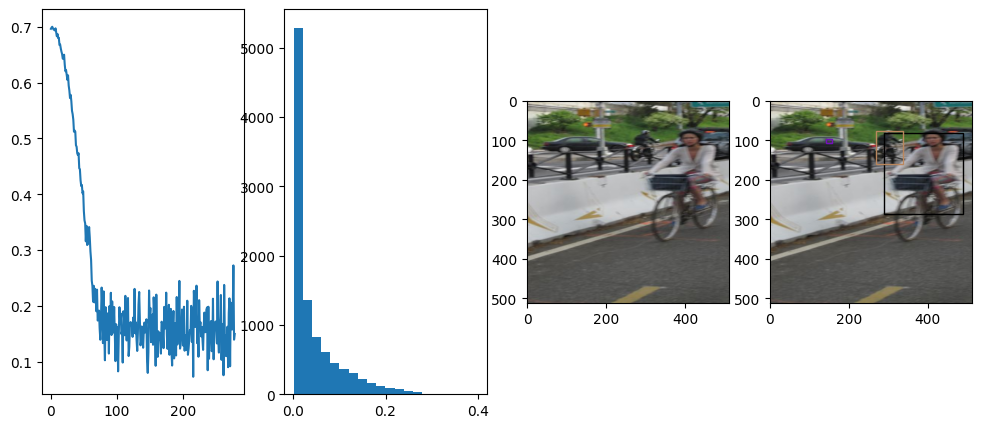

Epoch: 12, step: 315, last loss: 0.1830865442752838, num_ex: 8,             max pred iou: 0.2844632863998413,             mean pred iou: 0.04064781963825226             max target iou: 0.30780142545700073


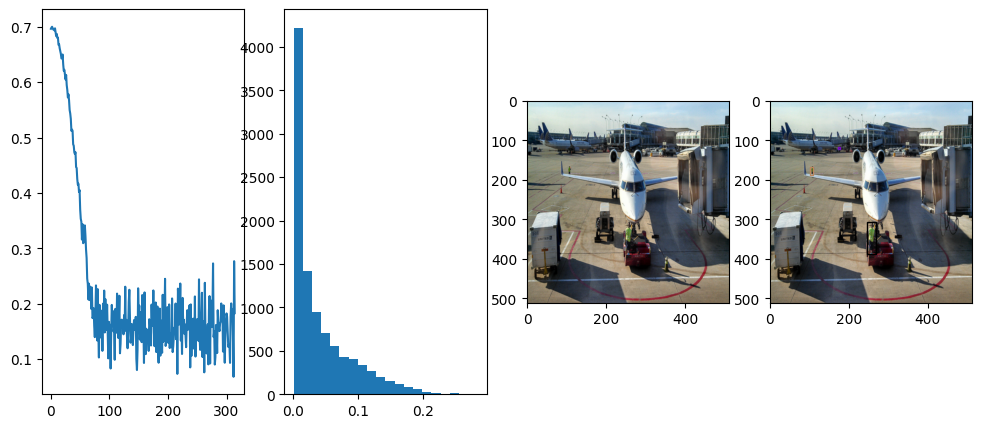

Epoch: 13, step: 350, last loss: 0.17460739612579346, num_ex: 11,             max pred iou: 0.31874173879623413,             mean pred iou: 0.04127562418580055             max target iou: 0.708180844783783


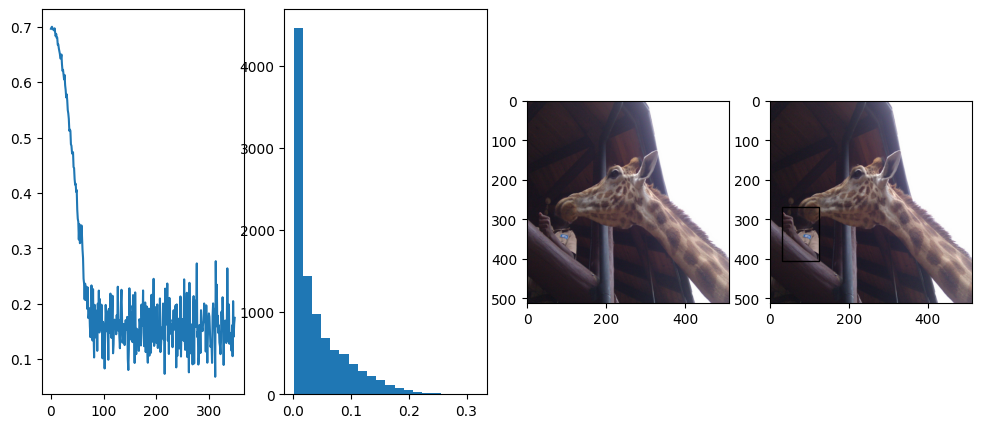

Epoch: 15, step: 385, last loss: 0.10819555073976517, num_ex: 11,             max pred iou: 0.22682079672813416,             mean pred iou: 0.035383403301239014             max target iou: 0.9436507821083069


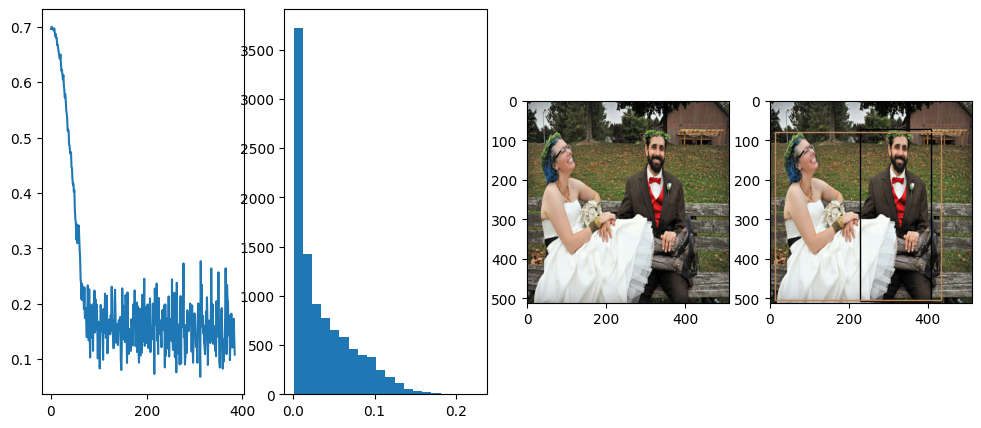

Epoch: 16, step: 420, last loss: 0.18511627614498138, num_ex: 8,             max pred iou: 0.5808603167533875,             mean pred iou: 0.06601216644048691             max target iou: 0.8347986340522766


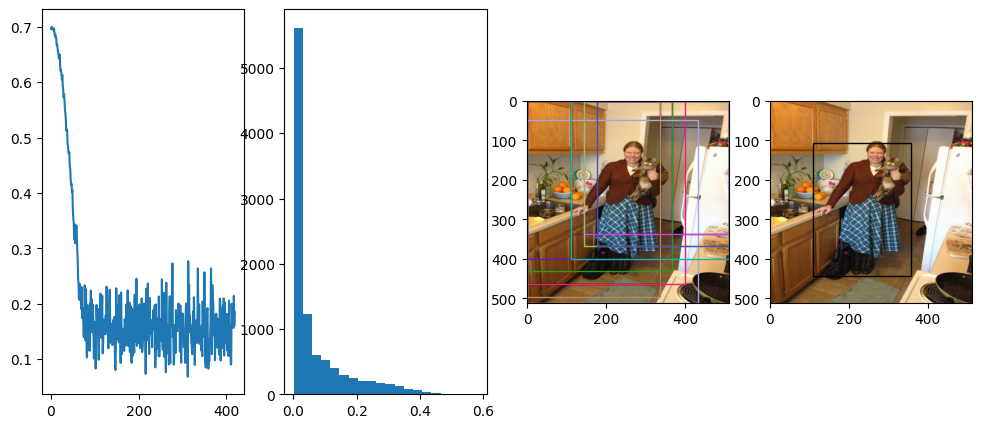

Epoch: 18, step: 455, last loss: 0.17086291313171387, num_ex: 24,             max pred iou: 0.33671340346336365,             mean pred iou: 0.05157165229320526             max target iou: 0.8644890785217285


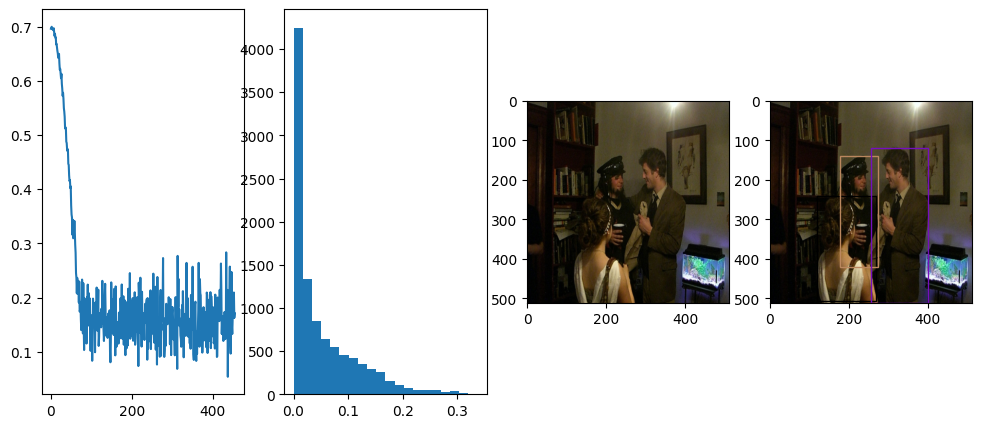

Epoch: 19, step: 490, last loss: 0.15413989126682281, num_ex: 12,             max pred iou: 0.3871948719024658,             mean pred iou: 0.054777536541223526             max target iou: 0.8193047046661377


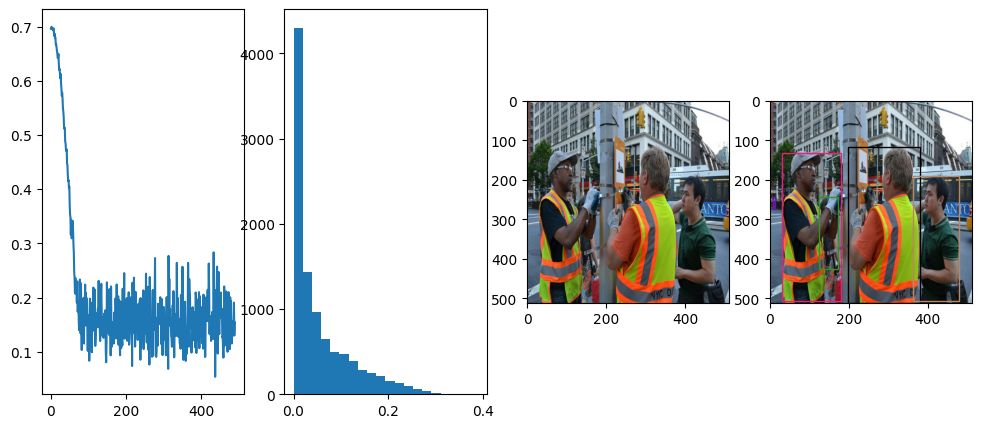

Epoch: 20, step: 525, last loss: 0.15802991390228271, num_ex: 14,             max pred iou: 0.30000123381614685,             mean pred iou: 0.04753590002655983             max target iou: 0.8582937717437744


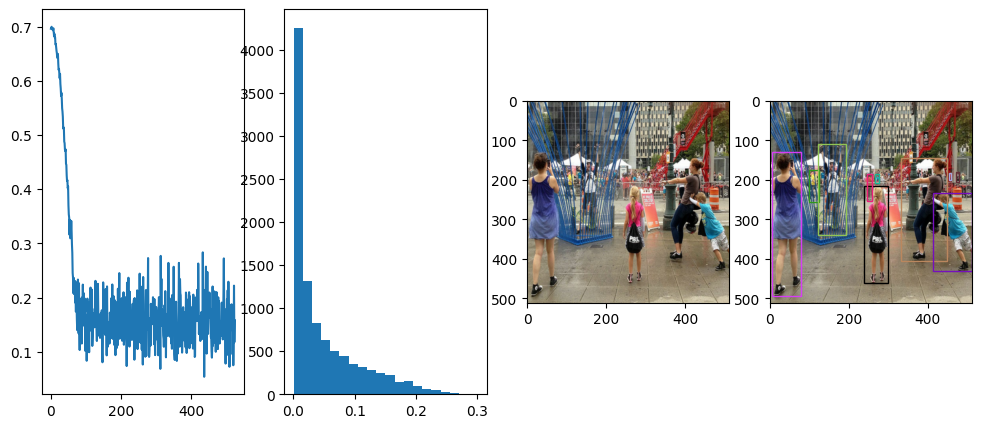

Epoch: 22, step: 560, last loss: 0.2168199121952057, num_ex: 15,             max pred iou: 0.23403698205947876,             mean pred iou: 0.022850163280963898             max target iou: 0.5936433672904968


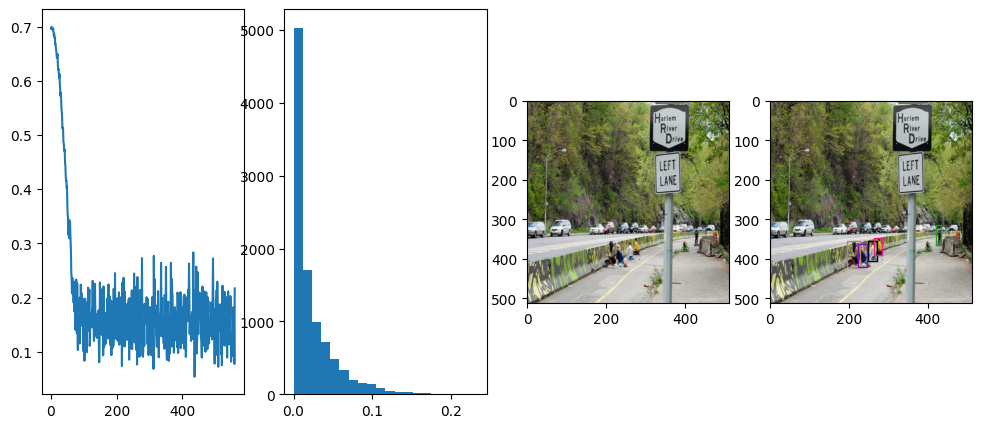

Epoch: 23, step: 595, last loss: 0.12589474022388458, num_ex: 8,             max pred iou: 0.3452413082122803,             mean pred iou: 0.044306423515081406             max target iou: 0.5159994959831238


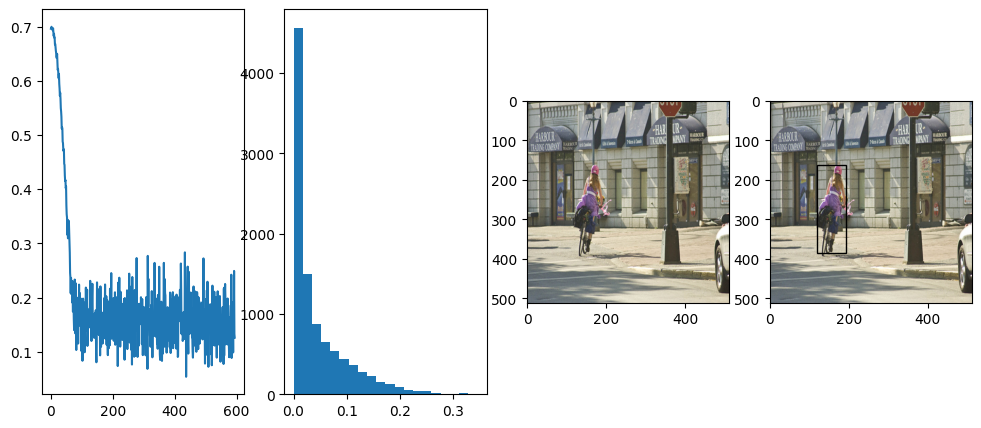

Epoch: 25, step: 630, last loss: 0.10721015930175781, num_ex: 24,             max pred iou: 0.2646265923976898,             mean pred iou: 0.036093708127737045             max target iou: 0.5830920934677124


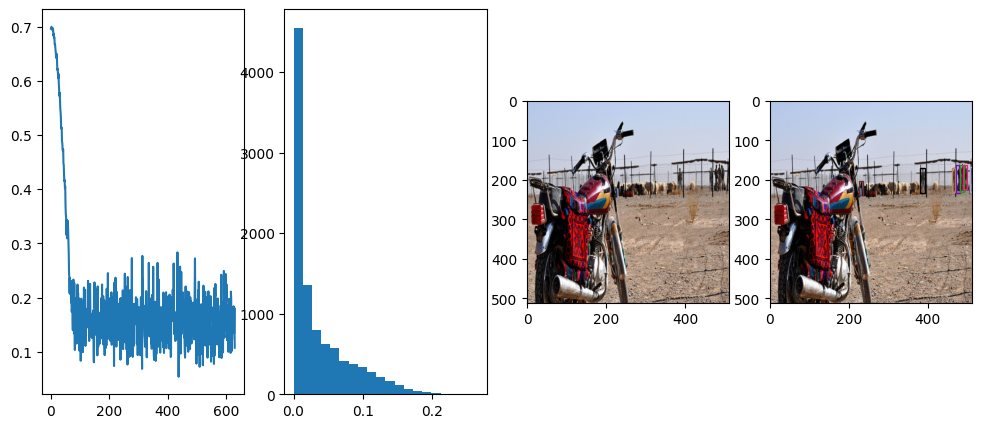

Epoch: 26, step: 665, last loss: 0.20465120673179626, num_ex: 35,             max pred iou: 0.3793485462665558,             mean pred iou: 0.0526399239897728             max target iou: 0.886635959148407


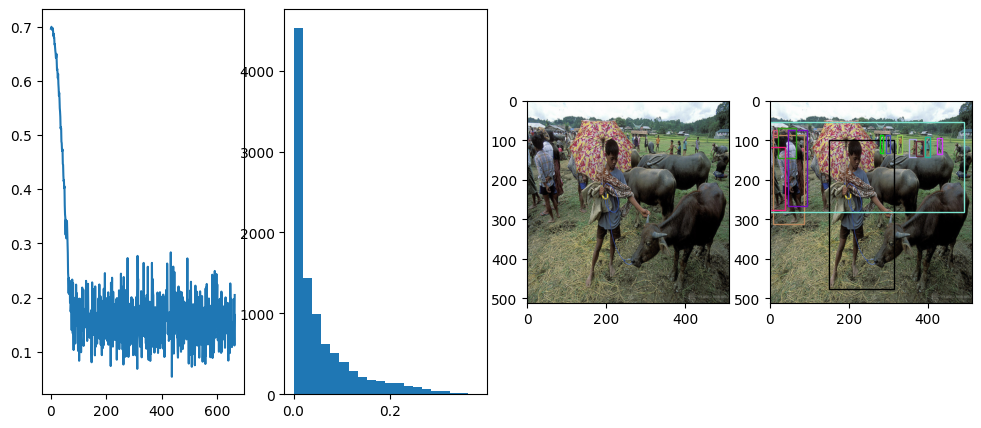

Epoch: 27, step: 700, last loss: 0.12312585860490799, num_ex: 6,             max pred iou: 0.48688578605651855,             mean pred iou: 0.07578461617231369             max target iou: 0.8826823234558105


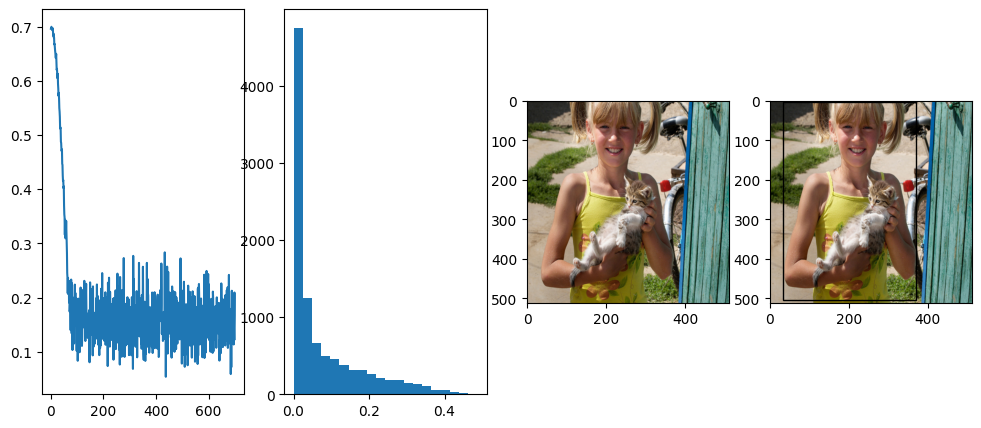

Epoch: 29, step: 735, last loss: 0.17622408270835876, num_ex: 23,             max pred iou: 0.4590037763118744,             mean pred iou: 0.08348941802978516             max target iou: 0.8668992519378662


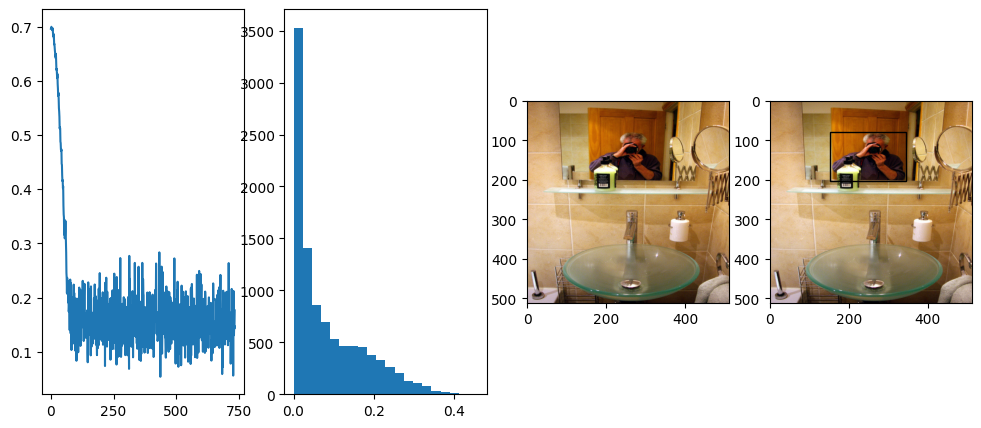

Epoch: 30, step: 770, last loss: 0.10061240941286087, num_ex: 19,             max pred iou: 0.5255197286605835,             mean pred iou: 0.04300406575202942             max target iou: 0.27137744426727295


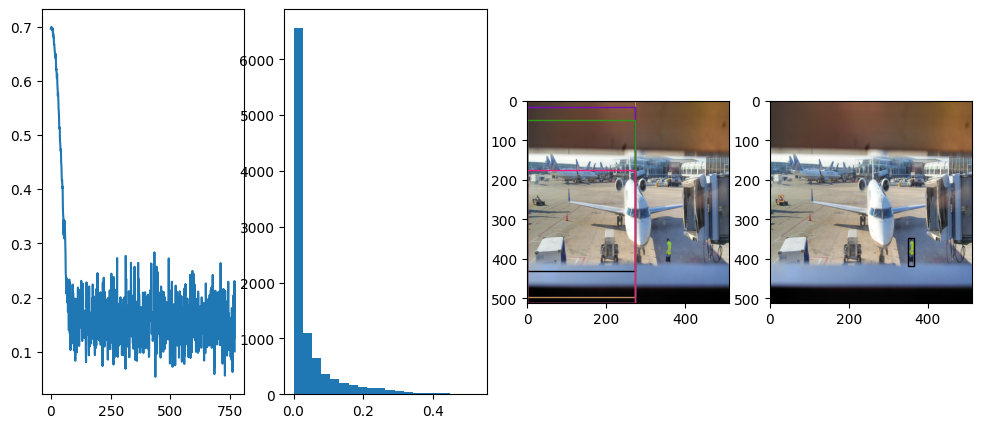

Epoch: 32, step: 805, last loss: 0.17627142369747162, num_ex: 11,             max pred iou: 0.4362870454788208,             mean pred iou: 0.06305618584156036             max target iou: 0.8766220211982727


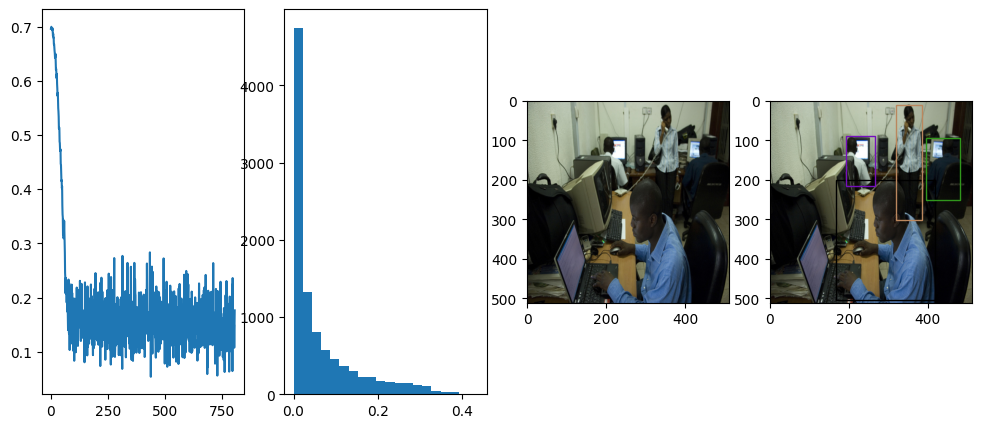

Epoch: 33, step: 840, last loss: 0.17660507559776306, num_ex: 16,             max pred iou: 0.46706780791282654,             mean pred iou: 0.052080556750297546             max target iou: 0.7422688603401184


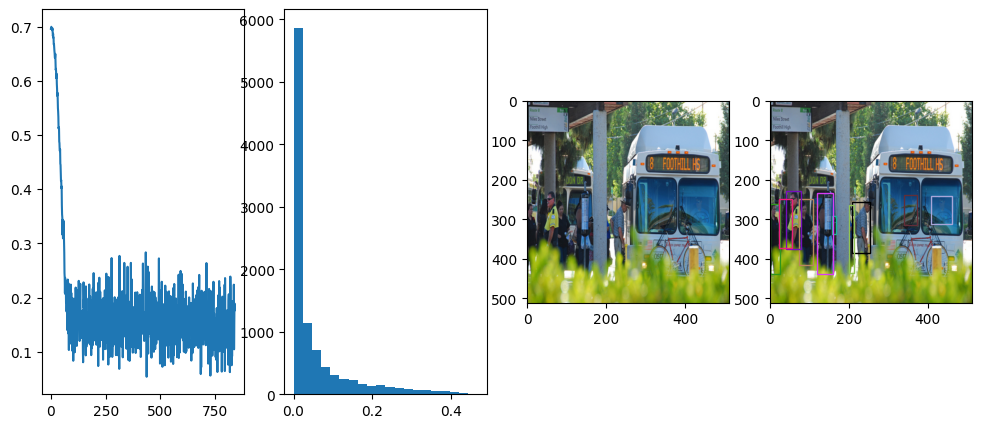

In [ ]:
epochs = 10000
losses = []
step = 0
step_show = 35
converted_anchors = convert_bbox(possible_anchors)
for epoch in range(epochs):
    for data in dataloader:
#if 1==1:
        optimizer.zero_grad()
        image_data = data['images'].to(device)
        temp_bs = len(image_data)
        bboxs = convert_bbox(data['bboxs'])
        img_ids = data['img_ids']
        target_rpn, target_indices_bbox = generate_target_iou_per_anchor(converted_anchors, bboxs, img_ids, temp_bs)
        target_rpn = target_rpn.to(device)
        
        rpn_output, _ = model(image_data)
        loss = loss_fn_rpn(rpn_output, target_rpn)
        if torch.isnan(loss):
            print('Problem')
        else:
            loss.backward()
            #break
            optimizer.step()
            scheduler.step()
            losses.append(loss.item())
            step += 1
        if step % step_show == 0:
            pred_iou = F.sigmoid(rpn_output.detach())
            print(f'Epoch: {epoch}, step: {step}, last loss: {loss.item()}, num_ex: {len(bboxs)}, \
            max pred iou: {pred_iou[0].max().item()}, \
            mean pred iou: {pred_iou[0].mean().item()} \
            max target iou: {target_rpn[0].max().item()}')
            fig, axs = plt.subplots(1, 4, figsize=(12, 5))
            axs[0].plot(losses)
            axs[1].hist(pred_iou[0].view(-1, 1).cpu(), bins=20)
            chosen_anchors = (F.sigmoid(rpn_output[0].cpu())>0.5)
            anchors_to_plot = possible_anchors[chosen_anchors]
            axs[2].imshow(image_data[0].cpu().permute(1, 2, 0).clip(0, 1))
            max_i = 0
            for i, row in enumerate(anchors_to_plot):
                rect = Rectangle(row[:2], row[2], row[3], edgecolor=(0.73 * i % 1, 0.53 * i % 1, 0.37 * i % 1), facecolor='none', linewidth=1)
                axs[2].add_patch(rect)
                max_i += 1
                if max_i > 100:
                    break
            axs[3].imshow(image_data[0].cpu().permute(1, 2, 0).clip(0, 1))
            max_i = 0
            for i, row in enumerate(data['bboxs'][img_ids==0]):
                rect = Rectangle(row[:2], row[2], row[3], edgecolor=(0.73 * i % 1, 0.53 * i % 1, 0.37 * i % 1), facecolor='none', linewidth=1)
                axs[3].add_patch(rect)
                max_i += 1
                if max_i > 100:
                    break
            plt.show()
            plt.close()
            

In [ ]:
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
config = resolve_data_config({}, model=model.baseline)
transform = create_transform(**config)

In [ ]:
bboxs[0]

In [ ]:
fig, axs = plt.subplots()
axs.imshow(image_data[0].cpu().permute(1, 2, 0).clip(0, 1))
for i, row in enumerate(bboxs[img_ids==0]):
    rect = Rectangle(row[:2], row[2]-row[0], row[3]-row[1], edgecolor=(0.73 * i % 1, 0.53 * i % 1, 0.37 * i % 1), facecolor='none', linewidth=1)
    axs.add_patch(rect)
plt.show()

In [ ]:
print(bboxs[img_ids==0][:, 2] - bboxs[img_ids==0][:, 0],
      bboxs[img_ids==0][:, 3] - bboxs[img_ids==0][:, 1],
      (bboxs[img_ids==0][:, 2] - bboxs[img_ids==0][:, 0])/
      (bboxs[img_ids==0][:, 3] - bboxs[img_ids==0][:, 1]))

In [ ]:
x = image_data.clone()
print(x.shape)
for param in model.baseline.children():
    x = param(x)
    print(x.shape)

In [ ]:
29*20